In [1]:
import numpy as np
import pandas as pd
import math as m
from scipy.stats import norm
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from hyperopt import fmin, tpe, hp

In [2]:
np.random.seed(1)

In [3]:
K = np.linspace(75,125,11).tolist()

In [4]:
# Heston Model
def heston_model(S,T,r,steps,Npaths,k,theta,v_0,rho,xi):
    dt = T/steps
    stock = np.zeros((Npaths,steps))
    vol = np.zeros((Npaths,steps))
    S_t = S
    v_t = v_0
    for i in range(steps):
        W = np.random.multivariate_normal(np.array([0,0]),cov = np.array([[1,rho],[rho,1]]),
                                          size = Npaths)*np.sqrt(dt)
        S_t = S_t*(np.exp((r-v_t*0.5)*dt +np.sqrt(v_t)*W[:,0]))
        v_t = np.maximum(v_t+k*(theta-v_t)*dt + xi*np.sqrt(v_t)*W[:,1],0)
        stock[:,i] = S_t
        vol[:,i] = v_t

    return stock, vol

s , v = heston_model(100,1,0.02,252,10000,1,0.04,0.04,-0.6,0.5)


P = np.zeros((10000,11))
for i in range(0,11):
    P[:,i] = np.maximum(s[:,-1] - K[i],0)

P = np.mean(P,axis = 0)
call_price = P*np.exp(-0.02*1)
call_price = call_price.tolist()
print(call_price)

[27.672013904280096, 23.2941234781173, 19.089351165496673, 15.125020284002431, 11.47222439678089, 8.224285791701883, 5.512507596524216, 3.4427204504095785, 2.03880203922076, 1.1776220820515564, 0.6740096344385075]


In [5]:
#BS Model
def bs_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)

In [6]:
bs_call(100,75,1,0.02,0.04)

26.48509950199336

In [7]:
bs_price = []
for i in range(len(K)):
    p = bs_call(100,K[i],1,0.02,0.04)
    bs_price.append(p)

In [8]:
bs_price

[26.48509950199336,
 21.58410613579582,
 16.68311462751595,
 11.783006505548528,
 6.938718311429511,
 2.763366574892075,
 0.5605898927581165,
 0.04800464803855142,
 0.0016571154227466578,
 2.3924901535577348e-05,
 1.5483504863550665e-07]

In [9]:
def MSE(true,predict):
    mse = np.square(np.subtract(true,predict)).mean()
    return mse

In [23]:
# heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
def tpe_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    def objective(parameters):
        s,v = heston_model(S,T,r,steps,Npaths,**parameters)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        mse = MSE(bs_price,call_price)
        return mse
    space = {
        'k': hp.uniform('k',0,1),
        'theta': hp.uniform('theta',0,1),
        'v_0': hp.uniform('v_0',0,1),
        'rho': hp.uniform('rho',0,1),
        'xi': hp.uniform('xi',0,5)
    }
    best = fmin(
        fn = objective,
        space = space,
        algo = tpe.suggest,
        max_evals = 100
        )
    print(best)

In [24]:
tpe_opt(bs_price,100,K,1,0.02,252,10000)

100%|██████████| 100/100 [00:22<00:00,  4.36trial/s, best loss: 0.07310833530410181]
{'k': 0.004327294939036087, 'rho': 0.21606458209879745, 'theta': 0.700783077301618, 'v_0': 0.001795857869096128, 'xi': 0.13734144262047382}


In [12]:
para = {'k': 0.004327294939036087, 'rho': 0.21606458209879745, 'theta': 0.700783077301618, 'v_0': 0.001795857869096128, 'xi': 0.13734144262047382}

In [25]:
s,v = heston_model(100,1,0.02,252,10000,**para)
P = np.zeros((10000,len(K)))
for i in range(len(K)):
    P[:,i] = np.maximum(s[:,-1] - K[i],0)

P = np.mean(P,axis = 0)
tpe_call_price = P*np.exp(-0.02*1)
tpe_call_price = tpe_call_price.tolist()
print(tpe_call_price)

[26.560786765624123, 21.65979339909036, 16.7588000325566, 11.858761092752852, 7.006283158487716, 2.7884353942960853, 0.5630610300582559, 0.05345228589764956, 0.0017395321809740175, 0.0, 0.0]


In [26]:
def bay_opt(bs_price,S,K,T,r,steps, Npaths):
    # K is a list of strike price
    def objective(k,theta,v_0,rho,xi):
        s,v = heston_model(S,T,r,steps, Npaths,k,theta,v_0,rho,xi)
        P = np.zeros((10000,len(K)))
        for i in range(len(K)):
            P[:,i] = np.maximum(s[:,-1] - K[i],0)

        P = np.mean(P,axis = 0)
        call_price = P*np.exp(-0.02*1)
        call_price = call_price.tolist()
        mse = MSE(bs_price,call_price)
        return -mse
    pbounds = {
        'k': (0,1),
        'theta': (0,1),
        'v_0': (0,1),
        'rho': (0,1),
        'xi': (0,5)
    }
    optimizer = BayesianOptimization(
        f = objective,
        pbounds = pbounds,
        random_state=1111,
        )
    optimizer.maximize(init_points=20, n_iter=100)
    print(optimizer.max)

In [15]:
#bay_opt(bs_price,100,K,1,0.02,252,10000)

In [16]:
para2 = {'k': 0.0, 'rho': 0.5608596672058875, 'theta': 0.2660447615314618, 'v_0': 0.0, 'xi': 3.0971193732685998}

In [17]:
s2,v2 = heston_model(100,1,0.02,252,10000,**para2)
P2 = np.zeros((10000,len(K)))
for i in range(len(K)):
    P2[:,i] = np.maximum(s2[:,-1] - K[i],0)

P2 = np.mean(P2,axis = 0)
bayes_call_price = P2*np.exp(-0.02*1)
bayes_call_price = bayes_call_price.tolist()
print(bayes_call_price)

[26.485099501988092, 21.58410613545463, 16.683112768921358, 11.782119402388503, 6.881126035856967, 1.9801326693227295, 0.0, 0.0, 0.0, 0.0, 0.0]


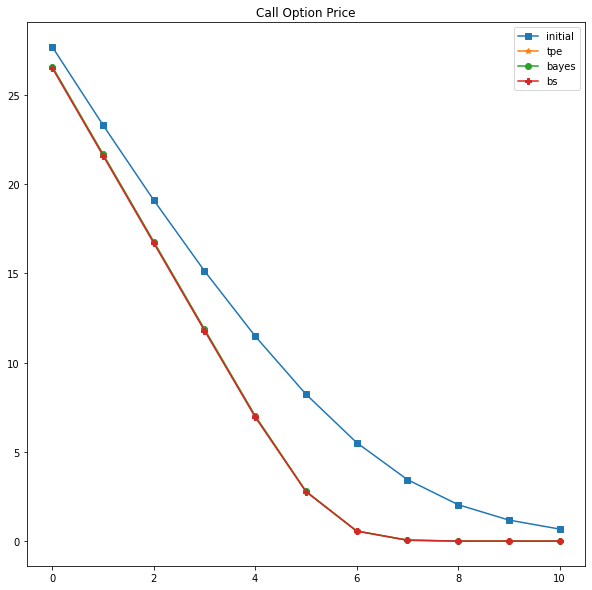

In [27]:
plt.figure(figsize=(10,10))
plt.plot(call_price,'s-',label='initial')
plt.plot(tpe_call_price,'*-',label='tpe')
plt.plot(tpe_call_price,'o-',label='bayes')
plt.plot(bs_price,'P-',label='bs')
plt.legend()
plt.title('Call Option Price')
plt.show()

In [28]:
def DIFF(real,predict):
    diff = []
    for i in range(len(real)):
        d = abs(real[i] - predict[i])
        diff.append(d)
    return diff

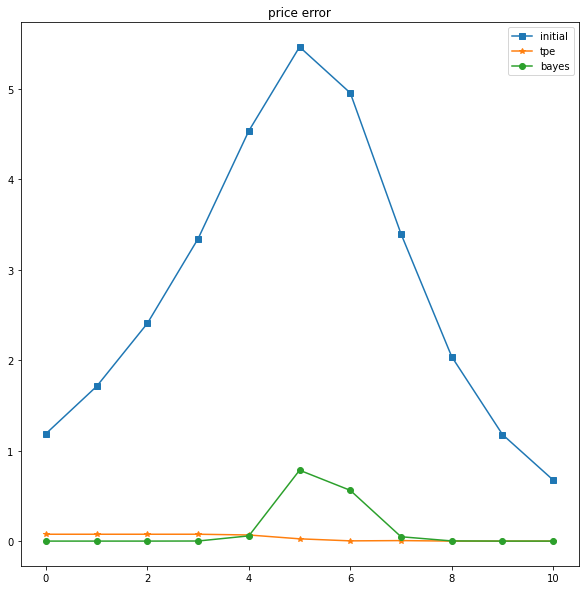

In [29]:
plt.figure(figsize=(10,10))
plt.plot(DIFF(bs_price,call_price),'s-',label='initial')
plt.plot(DIFF(bs_price,tpe_call_price),'*-',label='tpe')
plt.plot(DIFF(bs_price,bayes_call_price),'o-',label='bayes')
plt.legend()
plt.title('price error')
plt.show()